# Analyse ERA5 demand for NEM

In [37]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import pickle

import shap
#shap.initjs()

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [4]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [5]:
MARKET = "NEM" # "NEM" or "EU"

In [6]:
REMOVE_WEEKEND = True

In [7]:
REMOVE_XMAS = True

In [8]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [9]:
MASK_NAME = "pop_dens_mask"

In [10]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [11]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [12]:
N_FEATURES = "parsimonious"

In [13]:
DETREND = False

In [14]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load model data

In [15]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

Days to exclude

In [16]:
to_exclude = fn.read_results(
    "predictors_excluded", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [17]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    
    to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
    to_exc = to_exc.rename({"index": "time"})
    
    pred_ds[r] = ds.where(to_exc == 0)

In [20]:
# Population density mask, remove weekends and Xmas
features = fn.read_results(
    "feature_selection", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [21]:
hyperparameters = fn.read_results(
    "hyperparameters", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, 2020, 2020,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

### SHAP analysis

How do the predictors contribute to the predictions for the new training period (2010-2019) and the new test period (1959-2022)?

In [22]:
write_SHAP = True

In [23]:
dem_da = xr.open_dataset("/g/data/w42/dr6273/work/projects/Aus_energy/data/energy_demand/daily_demand_2010-2020_stl.nc")["demand_stl"]

In [ ]:
trainX_dict = {}
testX_dict = {}

shap_train = {}
shap_test = {}

explainer_train = {}
explainer_test = {}

for r in regions:
    cal = fn.get_calendar(MARKET, r)
    dem = fn.remove_time(dem_da, REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).sel(region=r)
    train_pred = fn.remove_time(pred_ds[r], REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, cal).drop(["demand", "is_workday"])
    test_pred = pred_ds[r].drop(["demand"])
        
    train_X = train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))).to_dataframe().values
    test_X = test_pred.to_dataframe().values
    train_y = dem.loc[slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR))].values
    
    # Remove rows with NaNs that we introduced earlier
    test_X = test_X[~np.isnan(test_X).any(axis=1), :]
    
    # And get dates that we keep
    to_exc = xr.Dataset.from_dataframe(to_exclude[r])["0"]
    to_exc = to_exc.rename({"index": "time"})
    index_keep = test_pred[list(test_pred.data_vars)[0]].where(to_exc == 0).dropna("time").time
    
    trainX_dict[r] = train_X
    testX_dict[r] = test_X
    
    filename_train = fn.get_filename(
        "SHAP_train", MARKET, r, MASK_NAME,
        FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
        REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
    )
    if DETREND:
        filename_train = filename_train + "_detrended"
        
    filename_test = fn.get_filename(
        "SHAP_test", MARKET, r, MASK_NAME,
        FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
        REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES
    )
    if DETREND:
        filename_test = filename_test + "_detrended"
    
    if write_SHAP:
        from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
        
        # Finalise model
        rf = ExtraTreesRegressor(
            n_estimators=int(hyperparameters[r].loc["n_estimators"].values),
            min_samples_leaf=int(hyperparameters[r].loc["min_samples_leaf"].values),
            max_depth=int(hyperparameters[r].loc["max_depth"].values),
            max_leaf_nodes=int(hyperparameters[r].loc["max_leaf_nodes"].values),
            random_state=0,
        )

        model_train, _ = fn.predict_forest(train_y, train_X, train_X, rf)
        model_test, _ = fn.predict_forest(train_y, train_X, test_X, rf)

        explainer = shap.Explainer(rf)
        # explain_train = explainer.shap_values(train_X)
        # explain_test = explainer.shap_values(test_X)
        explain_train = explainer(train_X)
        explain_test = explainer(test_X)
        
        # Pickle entire explainer
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "wb") as f:
             pickle.dump(explain_train, f)

        # Write SHAP values separately to csv
        shap_train[r] = pd.DataFrame(
            explain_train.values,
            index=pd.to_datetime(train_pred.sel(time=slice(str(FIRST_TRAIN_YEAR), str(LAST_TRAIN_YEAR)))["time"].values),
            columns=list(train_pred.data_vars)
        )
        shap_train[r].to_csv(
            RESULTS_PATH + "/SHAP/random_forest/" + filename_train + ".csv",
        )

        # Now for test
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "wb") as f:
             pickle.dump(explain_test, f)

        shap_test[r] = pd.DataFrame(
            explain_test.values,
            # index=pd.to_datetime(test_pred.sel(time=slice(str(FIRST_TEST_YEAR), str(LAST_TEST_YEAR)))["time"].values),
            index=pd.to_datetime(index_keep),
            columns=list(test_pred.data_vars)
        )

        shap_test[r].to_csv(
            RESULTS_PATH + "/SHAP/random_forest/" + filename_test + ".csv",
        )
        
    else:
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_train + ".pkl", "rb") as f:
             explainer_train[r] = pickle.load(f)
        with open(RESULTS_PATH + "/SHAP/random_forest/explainer_" + filename_test + ".pkl", "rb") as f:
             explainer_test[r] = pickle.load(f)

In [24]:
def plot_shap(vals, features, feature_names, colorbar=True, fontsize=10):
    """
    Custom shap summary plot
    """
    pl = shap.summary_plot(
        vals,
        features,
        feature_names=feature_names,
        plot_type="dot",
        cmap="viridis",
        color_bar=colorbar,
        show=False,
        plot_size=None
    )

    ax = plt.gca()
    for pos in ["top", "bottom", "left", "right"]:
        ax.spines[pos].set_visible(True)

    # xmin = roundup(np.min(vals), 1)
    # xmax = roundup(np.max(vals), 1)
    # if xmax - xmin > 800:
        # gap = 4000
    # elif xmax - xmin > 5000:
        # gap = 1000
    # else:
        # gap = 500
#     
    # ax.set_xticks(np.arange(xmin, xmax, gap))
    ax.axes.grid(visible=True)
    ax.axvline(0, c="k")
    ax.set_xlabel("SHAP value " + r"[GWh d$^{-1}$]", fontsize=fontsize)
    
    ax.yaxis.label.set_size(fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize, pad=0)
    
    # ax.set_yticklabels(range(vals.shape[1]), labelpad=0)
    
    # fig.colorbar(pl, ax=ax)
    
    return ax

Text(0.5, 0, 'Feature value')

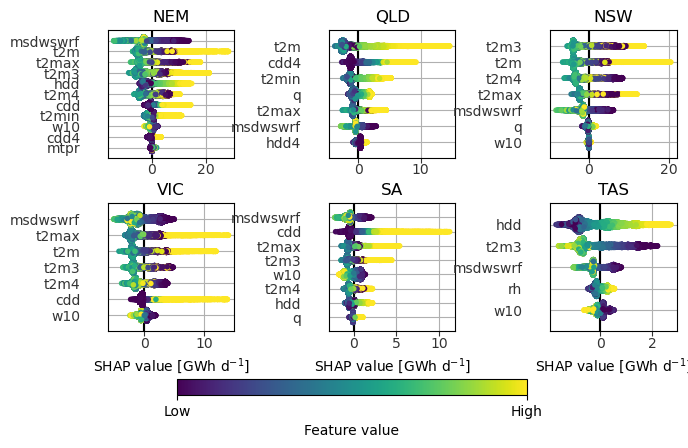

In [49]:
fig = plt.figure(figsize=(7,4))

for i, r in enumerate(regions):
    
    fig.add_subplot(2, 3, i+1)
    a = plot_shap(
        explainer_test[r].values / 1000,
        testX_dict[r],
        fn.parse_features(fn.sel_model(features[r])["feature_names"])[::-1],
        colorbar=False
    )
    a.set_title(r)
    # a.text(0.8, 0.05, r, transform=a.transAxes)
    
    if i in [0, 1, 2]:
        a.set_xlabel("")

plt.subplots_adjust(wspace=0.75, hspace=0.35)
    
# Figure legend
cmap = plt.get_cmap('viridis')
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=100)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=cmap)
scalarMap.set_array([])

cax = fig.add_axes([0.26, 0.0, 0.5, 0.04])
cbar = fig.colorbar(scalarMap, cax=cax, ticks=[0, 100], orientation="horizontal")
cbar.ax.set_xticklabels(["Low", "High"])
cbar.ax.set_xlabel("Feature value")

### Compare statistics of train (2010-2019) vs test (1959-2022)

In [34]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [35]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel(xlabel)

In [36]:
first_vars = [predictions[r].columns[0] for r in regions]

In [37]:
first_vars

['t2max', 't2max', 't2max', 't2max', 't2max', 'msdwswrf']

In [38]:
first_vars_units = ["[deg C]", "[deg C]", "[deg C]", "[deg C]", "[deg C]", r"[W m$^{-2}$]"]

In [39]:
second_vars = [predictions[r].columns[1] for r in regions]
second_vars

['msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'msdwswrf', 'hdd']

In [40]:
second_vars_units = [r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", r"[W m$^{-2}$]", "[deg C]"]

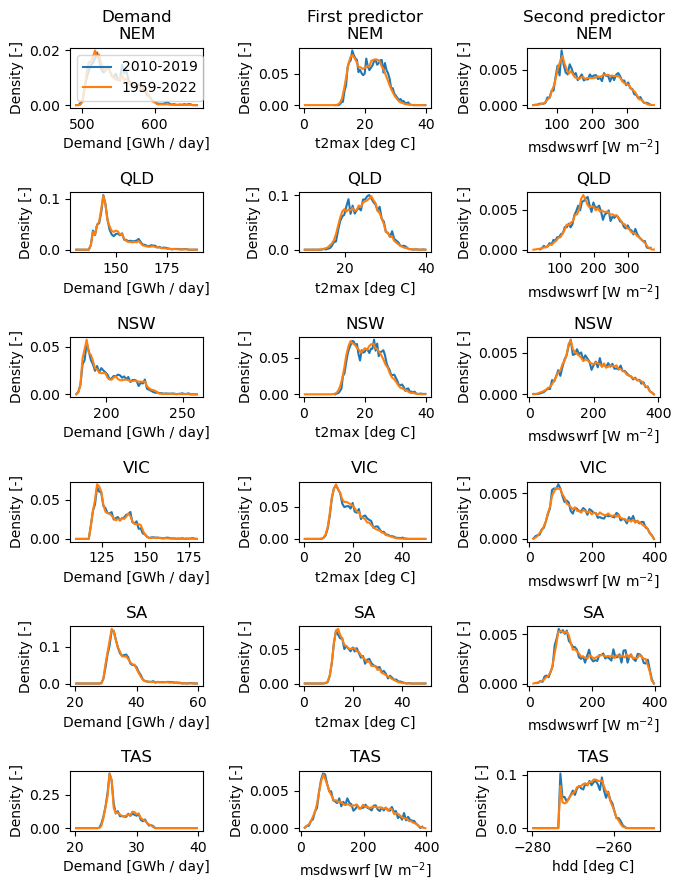

In [134]:
fig, ax = plt.subplots(6, 3, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     

    # ax[i,0].text(0.02, 0.8, r, transform=ax[i,0].transAxes)
    if i == 0:
        ax[i,0].legend()

    # Most important variable histograms
    if first_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2022")) + offset)
    ]
    plot_hist(ax[i,1], hists, ["2010-2019", "1959-2022"], first_vars[i] + " " + first_vars_units[i]) 
    
    # Second most important variable histograms
    if second_vars[i] in ["t2m", "t2m3", "t2m4", "t2max", "t2min", "cdd", "cdd3", "cdd4", "hdd", "hdd3", "hdd4"]:
        offset = -273.14
    else:
        offset = 0
        
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("2010", "2019")) + offset),
        get_hist(pred_ds[r][predictions[r].columns[1]].sel(time=slice("1959", "2022")) + offset)
    ]
    plot_hist(ax[i,2], hists, ["2010-2019", "1959-2022"], second_vars[i] + " " + second_vars_units[i]) 
    
    if i == 0:
        ax[i,0].set_title("Demand\n" + r)
        ax[i,1].set_title("First predictor\n" + r)
        ax[i,2].set_title("Second predictor\n" + r)
    else:
        ax[i,0].set_title(r)
        ax[i,1].set_title(r)
        ax[i,2].set_title(r)

plt.tight_layout()

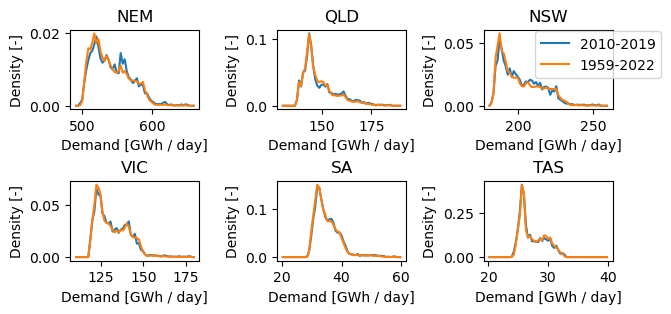

In [42]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2022")) / 1000)
    ]
    plot_hist(ax.flatten()[i], hists, ["2010-2019", "1959-2022"], "Demand [GWh / day]")     
    
    ax.flatten()[i].set_title(r)
    
ax[0,2].legend(loc=(0.4, 0.4))
plt.subplots_adjust(wspace=0.6, hspace=0.9)

### Time series of extreme demand days

In [43]:
def normalise(da, period=slice(None, None), dim="time"):
    """
    Normalise by removing mean and dividing by standard deviation
    """
    return (da - da.sel({dim: period}).mean(dim)) / da.sel({dim: period}).std(dim)

In [44]:
def extreme_days(da, q, period=slice(None, None), dim="time"):
    """
    Days above q, where q is computed over period
    """
    thresh = da.sel({dim: period}).quantile(q, dim)
    return da.where(da > thresh)

In [45]:
def plot_2d_series(ax, da, title):
    """
    Plot 2d time series
    """
    da.assign_coords({"region": range(6)}).plot(ax=ax)
    ax.set_yticks(range(6))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.set_title(title)

In [46]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [47]:
baseline = slice("1990", "2019")

In [48]:
q = 1 - 1 / (365 * 1)
print(q)

0.9972602739726028


In [49]:
ext_dpy = extreme_days(demand, q, baseline).resample(time="1YS").count()

In [50]:
ext_dpy.sum("time")

<xarray.DataArray 'demand' (region: 6)>
array([48, 50, 51, 48, 48, 64])
Coordinates:
  * region    (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'
    quantile  float64 0.9973

In [51]:
# Normalised annual mean demand
norm_mean = normalise(demand, baseline).resample(time="1YS").mean()

In [52]:
# Normalised annual maximum demand
norm_max = normalise(demand, baseline).resample(time="1YS").max()

In [53]:
# Monthly occurrences of extreme days
monthly_ext = extreme_days(demand, q, baseline).sel(time=baseline).groupby("time.month").count()

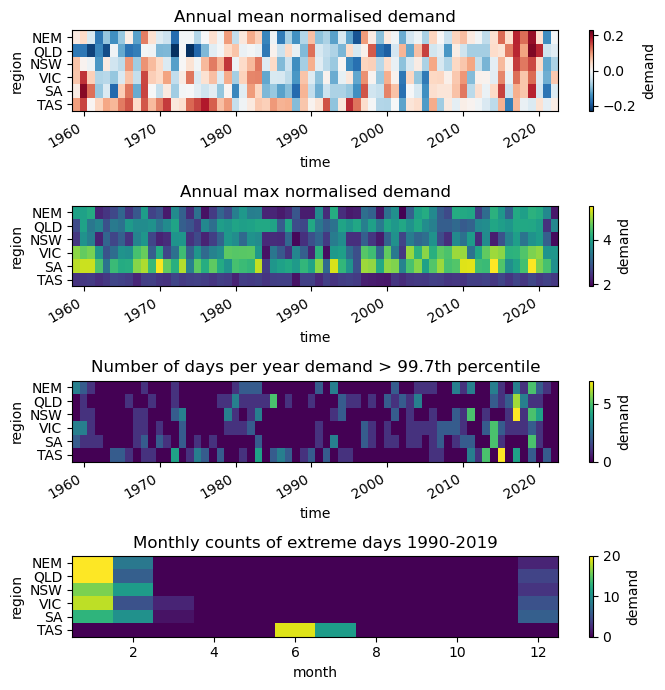

In [54]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7.))

plot_2d_series(ax[0], norm_mean, "Annual mean normalised demand")
plot_2d_series(ax[1], norm_max, "Annual max normalised demand")
plot_2d_series(ax[2], ext_dpy,
               "Number of days per year demand > " + str(np.round(q*100, 1)) + "th percentile"
              )
plot_2d_series(ax[3], monthly_ext, "Monthly counts of extreme days 1990-2019")
plt.tight_layout()

### Max demand on record

In [55]:
def get_days_around(date, n_before, n_after):
    """
    Return dates around a given date
    """
    return pd.date_range(date + pd.DateOffset(days=-n_before), date + pd.DateOffset(days=n_after), freq="D")

In [56]:
def normalise_monthly(da, dims=["time"], period=None):
    """
    Normalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: (x - x.mean(dims)) / x.std(dims))

In [57]:
def anomalise_monthly(da, dims=["time"], period=None):
    """
    Anomalise monthly with respect to period (a slice object)
    """
    if period == None:
        return da.groupby("time.month").apply(lambda x: x - x.mean(dims))
    else:
        return da.sel({"time": period}).groupby("time.month").apply(lambda x: x - x.mean(dims))

In [58]:
def plot_max(demand_da, roll, predictors_ds, normalise, days_before, days_after, var_axis_offset, ylabels, suptitle):
    """
    Plot maximum demand for a given averaging period.
    
    demand_da: array of demand
    roll: int, average to take mean over
    predictors_ds: dataset of predictors
    normalise: bool, whether to normalise demand and predictors
    days_before, days_after: int, days around maximum to plot
    var_axis_offset: dict in format k: [ax, offset], where k is the index of the variable,
        ax is the axis index on which to plot this variable, and offset is the value to add.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    """
    demand_da = demand_da / 1000
    dem_roll = demand_da.rolling(time=roll).mean()
    
    if normalise:
        demand_da = normalise_monthly(demand_da)
        dem_roll = normalise_monthly(dem_roll)
    
    dem_max = dem_roll.idxmax("time")
    days_around = get_days_around(dem_max.values, days_before, days_after)
    
    dem_roll_sel = dem_roll.sel(time=days_around)
    dem_sel = demand_da.sel(time=days_around)
    
    preds = list(predictors_ds.data_vars)[:-1]
    print(preds)
    preds_data = [predictors_ds[preds[i]].sel(time=days_around) for i in range(len(preds))]
    
    # Plot
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    dem_sel.plot(ax=ax[0,0], label="Daily")
    dem_roll_sel.plot(ax=ax[0,0], label=str(roll) + "-day")
    ax[0,0].set_title("")
    
    for i, var in enumerate(preds):
        if var_axis_offset[i] is not None:
            (preds_data[i] + var_axis_offset[i][0]).plot(ax=ax.flatten()[var_axis_offset[i][1]], label=preds[i])
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(dem_max.values, c="k")
        a.legend(loc=[0,1], ncols=2, frameon=False)
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))
        
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


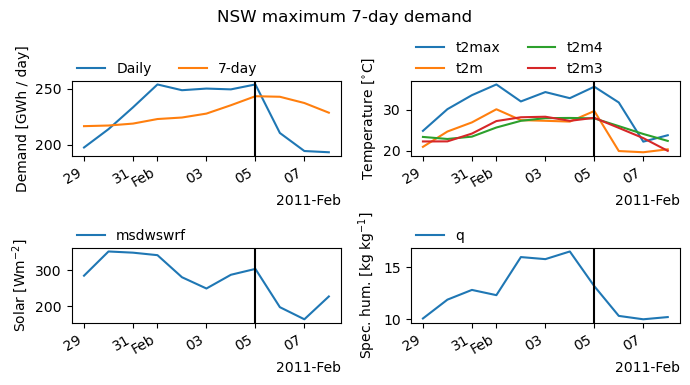

In [59]:
plot_max(
    demand.sel(region="NSW"),
    7,
    pred_ds["NSW"],
    False,
    7,
    3,
    {
        0: [-273.15, 1],
        2: [-273.15, 1],
        5: [-273.15, 1],
        6: [-273.15, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
    "NSW maximum 7-day demand"
)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


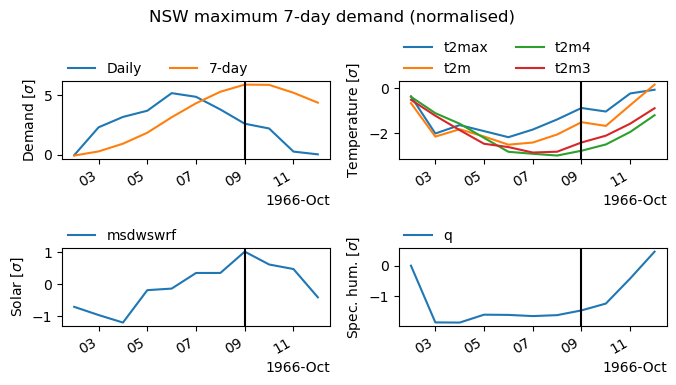

In [60]:
plot_max(
    normalise_monthly(demand.sel(region="NSW")),
    7,
    normalise_monthly(pred_ds["NSW"]),
    True,
    7,
    3,
    {
        0: [0, 1],
        2: [0, 1],
        5: [0, 1],
        6: [0, 1],
        1: [0, 2],
        3: [0, 3],
        4: None
    },
    [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
    "NSW maximum 7-day demand (normalised)"
)

### Composite evolution on extreme days

In [61]:
def get_cases(da, times, days_before, days_after):
    """
    Return an array that selects and reshapes da according to times provided, 
    with some days prior and after each time.
    """
    da_list = []
    for time in times:
        days_around = get_days_around(time, days_before, days_after)
        idx_days_around = range(-days_before, days_after+1)
        
        _da = da.sel(time=days_around)
        _da = _da.rename({"time": "days_around"})
        _da = _da.assign_coords({"days_around": idx_days_around})
        _da = _da.expand_dims({"time": [time]})
        da_list.append(_da)
    return xr.concat(da_list, "time")

In [62]:
def subset_events(da, window):
    """
    Returns last times from da that fall within a window.
    E.g. if you want events that occur within a week to be a single event,
    set window=7.
    """
    days_diff = da["time"].to_series().diff().dt.days # difference between days
    mask = days_diff < window # where dys fall within the window
    group = (~mask).cumsum() # Assign groups to events
    events = days_diff.groupby(group).tail(1) # final day of event    
    return da.sel(time=events.index) # Select events of da

In [63]:
def get_events_data(predictors_ds, roll, q, days_before, days_after, event_window, normalise=False):
    """
    Return demand and predictor data for extreme events, plus days either side
    
    predictors_ds: dataset of demand and predictors
    roll: moving average length to determine extreme events
    q: extreme event threshold
    days_before, days_after: days around event
    event_window: threshold to exclude consecutive days from being individual events
    normalise: bool, whether to normalise data before finding events
    """ 
    ext_dict = {}
    for r in regions:
        # Moving average of demand data. This is used to compute extreme events
        demand_roll = predictors_ds[r]["demand"].rolling(time=roll).mean()

        # Get dates of events
        dem_ext = extreme_days(demand_roll, q=q) # Days above q
        dem_ext = dem_ext.dropna("time")
        dem_events = subset_events(dem_ext, event_window) # Don't count days within a window
        
        if normalise:
            # Get dates of events before normalising
            dem_ext = extreme_days(demand_roll, q=q) # Days above q
            dem_ext = dem_ext.dropna("time")
            dem_events = subset_events(dem_ext, event_window) # Don't count days within a window
            
            # Now normalise
            demand_roll = normalise_monthly(demand_roll)
            preds = normalise_monthly(predictors_ds[r])
        else:
            preds = predictors_ds[r]
       

        # Extract events from da
        ext_dict[r] = get_cases(
            demand_roll,
            dem_events["time"].values,
            days_before,
            days_after
        ).to_dataset(name="demand_" + str(roll))

        # Repeat for all predictors
        data_vars = list(preds.data_vars)
        for name in data_vars:
            da = preds[name]

            var_cases = get_cases(
                da,
                dem_events["time"].values,
                days_before,
                days_after
            )

            ext_dict[r][name] = var_cases
            
    return ext_dict

In [64]:
def get_event_plot_params():
    """
    Returns a nested dict of plotting parameters for event plots
    """
    plot_params = {
        "original": {},
        "normalised": {}
    }
    
    plot_params["original"]["NEM"] = {
        "data": events_dict["NEM"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            3: [0, 2, "tab:purple"],
            5: [0, 2, "tab:pink"],
            1: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None,
            7: None,
            8: None,
            9: None,
            10: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Degree day [$^{\circ}$C]", r"Solar [Wm$^{-2}$]"],
        "suptitle": "NEM extreme " + str(roll) + "-day demand (" + str(len(events_dict["NEM"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["NEM"] = {
        "data": norm_events_dict["NEM"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            3: [0, 2, "tab:purple"],
            5: [0, 2, "tab:pink"],
            1: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None,
            7: None,
            8: None,
            9: None,
            10: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Degree day [$\sigma$]", r"Solar [$\sigma$]"],
        "suptitle": "NEM extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["NEM"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["QLD"] = {
        "data": events_dict["QLD"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:purple"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"CDD [$^{\circ}$C]"],
        "suptitle": "QLD extreme " + str(roll) + "-day demand (" + str(len(events_dict["QLD"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["QLD"] = {
        "data": norm_events_dict["QLD"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:purple"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"CDD [$\sigma$]"],
        "suptitle": "QLD extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["QLD"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["NSW"] = {
        "data": events_dict["NSW"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:purple"],
            6: [-273.15, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
        "suptitle": "NSW extreme " + str(roll) + "-day demand (" + str(len(events_dict["NSW"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["NSW"] = {
        "data": norm_events_dict["NSW"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:purple"],
            6: [0, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
        "suptitle": "NSW extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["NSW"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["VIC"] = {
        "data": events_dict["VIC"],
        "details": {
            0: [-273.15, 1, "gray"],
            2: [-273.15, 1, "tab:blue"],
            5: [-273.15, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Wind speed [ms$^{-1}$]"],
        "suptitle": "VIC extreme " + str(roll) + "-day demand (" + str(len(events_dict["VIC"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["VIC"] = {
        "data": norm_events_dict["VIC"],
        "details": {
            0: [0, 1, "gray"],
            2: [0, 1, "tab:blue"],
            5: [0, 1, "tab:pink"],
            1: [0, 2, "gray"],
            3: [0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            6: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Wind speed [$\sigma$]"],
        "suptitle": "VIC extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["VIC"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["SA"] = {
        "data": events_dict["SA"],
        "details": {
            0: [-273.15, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            5: None,
            6: None,
            7: None
        },
        "ylabels": ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"HDD [$^{\circ}$C]"],
        "suptitle": "SA extreme " + str(roll) + "-day demand (" + str(len(events_dict["SA"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["SA"] = {
        "data": norm_events_dict["SA"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
            5: None,
            6: None,
            7: None
        },
        "ylabels": [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"HDD [$\sigma$]"],
        "suptitle": "SA extreme " + str(roll) + "-day normalised demand (" + str(len(norm_events_dict["SA"].time.values)) + " events)",
        "GWh": False
    }
    
    plot_params["original"]["TAS"] = {
        "data": events_dict["TAS"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
        },
        "ylabels": ["Demand [GWh / day]", r"Solar [Wm$^{-2}$]", r"HDD [$^{\circ}$C]", r"Wind speed [ms$^{-1}$]"],
        "suptitle": "TAS extreme " + str(roll) + "-day demand (" + str(len(events_dict["TAS"].time.values)) + " events)",
        "GWh": True
    }
    plot_params["normalised"]["TAS"] = {
        "data": norm_events_dict["TAS"],
        "details": {
            0: [0, 1, "gray"],
            1: [0, 2, "gray"],
            2: [0, 3, "gray"],
            3: None,#[0, 3, "gray"],
            4: None,#[0, 3, "gray"],
        },
        "ylabels": ["Demand [$\sigma$]", r"Solar [$\sigma$]", r"HDD [$\sigma$]", r"Wind speed [$\sigma$]"],
        "suptitle": "TAS extreme " + str(roll) + "-day demand (" + str(len(norm_events_dict["TAS"].time.values)) + " events)",
        "GWh": False
    }
    
    return plot_params

In [65]:
from matplotlib.lines import Line2D

In [66]:
def plot_events(ds, axis_details, ylabels, suptitle, plot_range=False, to_GWh=False, plot_zero=False):
    """
    Plot maximum demand for a given averaging period.
    
    ds: dataset of demand and predictors for events
    axis_details: dict in format k: [ax, offset, color], where k is the index of the variable,
        ax is the axis index on which to plot this variable, offset is the value to add,
        and color is the line color.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    plot_range: plot range of data rather than all lines
    to_GWh: bool, whether to divide demand arrays by 1000
    plot_zero: bool, whether or not to plot y=0
    """
    def _plot_lines(ax, da, color, label):
        p = da.plot.line(ax=ax, x="days_around", c=color, label=label, add_legend=False, lw=1)
    def _plot_range(ax, da, color, label):
        ax.fill_between(da.days_around, da.min("time"), da.max("time"), color=color, alpha=0.3)
        p = ax.plot(da.days_around, da.mean("time"), color=color)
        
    data_vars = list(ds.data_vars)
    
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    demand = ds["demand"]
    demand_roll = ds[data_vars[0]]
    if to_GWh:
        demand = ds["demand"] / 1000
        demand_roll = ds[data_vars[0]] / 1000
        
    if plot_range:
        _plot_range(ax[0,0], demand, "lightgray", "Daily")
        _plot_range(ax[0,0], demand_roll, "k", data_vars[0].split("_")[1] + "-day")
    else:
        _plot_lines(ax[0,0], demand, "lightgray", "Daily")
        _plot_lines(ax[0,0], demand_roll, "k", data_vars[0].split("_")[1] + "-day")
    
    # Legend colors and labels as a list of lists (one list per panel)
    legend_colors = [
        ["lightgray", "k"],
        [],
        [],
        []
    ]
    legend_handles = [
        ["Daily", data_vars[0].split("_")[1] + "-day"],
        [],
        [],
        []
    ]

    ax[0,0].set_title("")
    
    print(data_vars[1:-1])
    for i, var in enumerate(data_vars[1:-1]):
        if axis_details[i] is not None:
            da = ds[var] + axis_details[i][0]
            
            if plot_range:
                _plot_range(ax.flatten()[axis_details[i][1]], da, axis_details[i][2], var)
            else:
                _plot_lines(ax.flatten()[axis_details[i][1]], da, axis_details[i][2], var)
                
            legend_colors[axis_details[i][1]].append(axis_details[i][2])
            legend_handles[axis_details[i][1]].append(var)
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(0, c="k", ls="--")
        a.set_title("")
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        if plot_zero:
            a.axhline(0, c="k", ls="--")
        
        # Custom legend
        lines = [Line2D([0], [0], color=c) for c in legend_colors[i]]
        a.legend(lines, legend_handles[i], loc=(0, 1), ncol=2, frameon=False)
            
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()
    
    # return fig

In [68]:
roll = 7
days_before = 10
days_after = 3
event_window = 7
q = 1 - 1 / (365 * 3)
print(q)

0.9990867579908675


In [69]:
events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window)

KeyError: "not all values found in index 'time'"

In [52]:
norm_events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window, True)

In [67]:
event_plot_params = get_event_plot_params()

NameError: name 'events_dict' is not defined

In [91]:
for data_type in ["original", "normalised"]:
    
    if data_type == "normalised":
        plot_zero = True
    else:
        plot_zero = False
        
    for plot_range in [False, True]:
        for r in regions:

            plot_events(
                event_plot_params[data_type][r]["data"],
                event_plot_params[data_type][r]["details"],
                event_plot_params[data_type][r]["ylabels"],
                event_plot_params[data_type][r]["suptitle"],
                plot_range=plot_range,
                to_GWh=event_plot_params[data_type][r]["GWh"],
                plot_zero=plot_zero
            )

            fp = "./figures/extreme_" + str(roll) + "day_events_" + r + "_" + data_type
            if plot_range:
                fp += "_range"

            plt.savefig(fp + ".pdf", format="pdf", bbox_inches="tight")
            plt.close()

['t2max', 'msdwswrf', 't2m', 'cdd4', 'mtpr', 'hdd', 'w10', 'cdd', 't2min', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'cdd4', 'q', 't2min', 'hdd4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 't2m3']
['t2max', 'msdwswrf', 'hdd', 'q', 'w10', 'cdd', 't2m4', 't2m3']
['msdwswrf', 'hdd', 'w10', 'rh', 't2m3']
['t2max', 'msdwswrf', 't2m', 'cdd4', 'mtpr', 'hdd', 'w10', 'cdd', 't2min', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'cdd4', 'q', 't2min', 'hdd4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 't2m3']
['t2max', 'msdwswrf', 'hdd', 'q', 'w10', 'cdd', 't2m4', 't2m3']
['msdwswrf', 'hdd', 'w10', 'rh', 't2m3']
['t2max', 'msdwswrf', 't2m', 'cdd4', 'mtpr', 'hdd', 'w10', 'cdd', 't2min', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'cdd4', 'q', 't2min', 'hdd4']
['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']
['t2max', 'msdwswrf', 't2m', 'w10', 'cdd', 't2m4', 

### Color by season

In [120]:
def plot_season_events(ds, axis_details, ylabels, suptitle, plot_range=False, to_GWh=False, plot_zero=False):
    """
    Plot maximum demand for a given averaging period.
    
    ds: dataset of demand and predictors for events
    axis_details: dict in format k: [ax, offset, color], where k is the index of the variable,
        ax is the axis index on which to plot this variable, offset is the value to add,
        and color is the line color.
        If you don't want to plot a variable, set the value to None.
    ylabels: list, ylabels
    suptitle: figure title
    plot_range: plot range of data rather than all lines
    to_GWh: bool, whether to divide demand arrays by 1000
    plot_zero: bool, whether or not to plot y=0
    """
    def _plot_lines(ax, da, color, label):
        da.plot.line(ax=ax, x="days_around", c=color, label=label, add_legend=False, lw=1)
    def _plot_range(ax, da, color, label):
        ax.fill_between(da.days_around, da.min("time"), da.max("time"), color=color, alpha=0.3)
        ax.plot(da.days_around, da.mean("time"), color=color)
        
    def _sel_winter(da):
        return da.where(da.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
    def _sel_summer(da):
        return da.where(da.time.dt.month.isin([10, 11, 12, 1, 2, 3]))
        
    data_vars = list(ds.data_vars)
    
    fig, ax = plt.subplots(2, 2, figsize=(7,4))
    
    demand = ds["demand"]
    demand_roll = ds[data_vars[0]]
    if to_GWh:
        demand = ds["demand"] / 1000
        demand_roll = ds[data_vars[0]] / 1000
        
    if plot_range:
        _plot_range(ax[0,0], _sel_winter(demand_roll), "tab:blue", "Winter")
        _plot_range(ax[0,0], _sel_summer(demand_roll), "tab:orange", "Summer")
    else:
        _plot_lines(ax[0,0], _sel_winter(demand_roll), "tab:blue", "Winter")
        _plot_lines(ax[0,0], _sel_summer(demand_roll), "tab:orange", "Summer")

    ax[0,0].set_title("")
    
    lines = [Line2D([0], [0], color=c) for c in ["tab:blue", "tab:orange"]]
    ax[0,0].legend(lines, ["Winter", "Summer"], loc=(0, 1), ncol=2, frameon=False)
    
    print(data_vars[1:-1])
    for i, var in enumerate(data_vars[1:-1]):
        if axis_details[i] is not None:
            da = ds[var] + axis_details[i][0]
            
            if plot_range:
                _plot_range(ax.flatten()[axis_details[i][1]], _sel_winter(da), "tab:blue", var)
                _plot_range(ax.flatten()[axis_details[i][1]], _sel_summer(da), "tab:orange", var)
            else:
                _plot_lines(ax.flatten()[axis_details[i][1]], _sel_winter(da), "tab:blue", var)
                _plot_lines(ax.flatten()[axis_details[i][1]], _sel_summer(da), "tab:orange", var)
                
            ax.flatten()[axis_details[i][1]].set_title(var)
        
    for i, a in enumerate(ax.flatten()):
        a.axvline(0, c="k", ls="--")
        # a.set_title("")
        # a.legend(loc=[0,1], ncols=2, frameon=False)
        a.set_ylabel(ylabels[i])
        a.set_xlabel("")
        if plot_zero:
            a.axhline(0, c="k", ls="--")
        # a.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(a.xaxis.get_major_locator()))#.DateFormatter('%Y-%m-%d'))
                
    plt.suptitle(suptitle, y=0.95)
    # plt.subplots_adjust(wspace=0.3, hspace=1.)
    plt.tight_layout()

In [101]:
roll = 14
days_before = 14
days_after = 3
event_window = 7
q = 1 - 1 / (365 * 3)
print(q)

0.9990867579908675


In [102]:
events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window)

In [103]:
norm_events_dict = get_events_data(pred_ds, roll, q, days_before, days_after, event_window, True)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


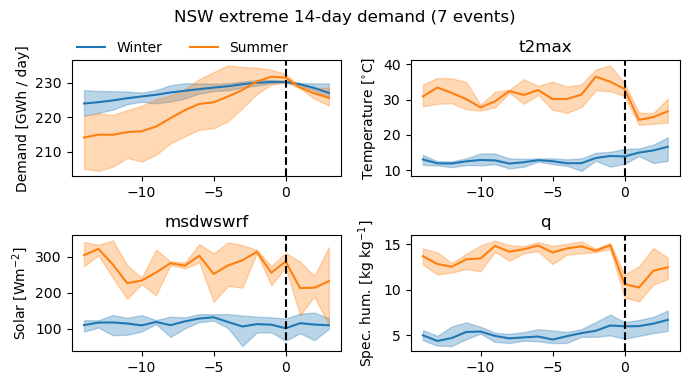

In [121]:
plot_season_events(
    events_dict["NSW"],
    {
        0: [-273.15, 1, "gray"],
        2: None,#[0, 1, "tab:blue"],
        5: None,#[0, 1, "tab:purple"],
        6: None,#[0, 1, "tab:pink"],
        1: [0, 2, "gray"],
        3: [0, 3, "gray"],
        4: None
    },
    ["Demand [GWh / day]", r"Temperature [$^{\circ}$C]", r"Solar [Wm$^{-2}$]", r"Spec. hum. [kg kg$^{-1}$]"],
    "NSW extreme " + str(roll) + "-day demand (" + str(len(events_dict["NSW"].time.values)) + " events)",
    plot_range=True,
    to_GWh=True
)

['t2max', 'msdwswrf', 't2m', 'q', 'w10', 't2m4', 't2m3']


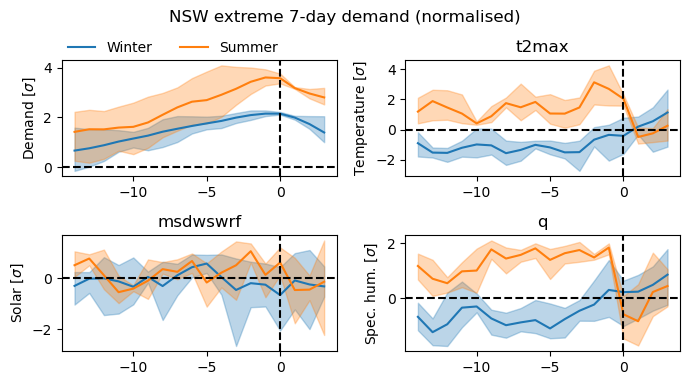

In [122]:
plot_season_events(
    norm_events_dict["NSW"],
    {
        0: [0, 1, "gray"],
        2: None,#[0, 1, "tab:blue"],
        5: None,#[0, 1, "tab:purple"],
        6: None,#[0, 1, "tab:pink"],
        1: [0, 2, "gray"],
        3: [0, 3, "gray"],
        4: None
    },
    [r"Demand [$\sigma$]", r"Temperature [$\sigma$]", r"Solar [$\sigma$]", r"Spec. hum. [$\sigma$]"],
    "NSW extreme 7-day demand (normalised)",
    True,
    False,
    plot_zero=True
)